In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
import tangram as tg

In [5]:
# import squidpy as sq
# from anndata import AnnData
# import pathlib
# import matplotlib as mpl
# import skimage
# import seaborn as sns

# sc.logging.print_header()
# print(f"squidpy=={sq.__version__}")

# %load_ext autoreload
# %autoreload 2

In [5]:
# https://www.nature.com/articles/s41467-022-35297-z#data-availability

exp = pd.read_csv('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/human_kidney_scRNA/exprMatrix.tsv.gz', sep='\t', compression='gzip', index_col=0)
adata_sc = sc.AnnData(exp.T)
adata_sc

AnnData object with n_obs × n_vars = 27677 × 22484

In [6]:
metadata = pd.read_csv('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/human_kidney_scRNA/meta.tsv', sep='\t', index_col=0)
adata_sc.obs = metadata.loc[adata_sc.obs_names]

In [7]:
print(adata_sc.obs.columns)
adata_sc.obs.head(3)

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampletype', 'sex',
       'sampleID', 'CMVstatus', 'percent.mt', 'Group', 'Female', 'Male',
       'log10GenesPerUMI', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8',
       'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'percent.ribo',
       'Cell_Types_Broad', 'Cell_Types_Subclusters', 'Cluster'],
      dtype='object')


,orig.ident,nCount_RNA,nFeature_RNA,sampletype,sex,sampleID,CMVstatus,percent.mt,Group,Female,...,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,S.Score,G2M.Score,Phase,percent.ribo,Cell_Types_Broad,Cell_Types_Subclusters,Cluster
HKB10_AAAGGATTCGGTGAAG-1,HKB10,70498.055,7827,LD,Female,CD45_1,Neg,31.984370,CD45,FemaleCD1,...,2283,14,14,-0.003080,-0.018163,G1,9.328123,CNT,CNT,14
HKB10_AAAGGTAAGGGACAGG-1,HKB10,1450.258,929,LD,Female,CD45_1,Neg,1.214334,CD45,FemaleCD1,...,1262,17,17,0.000171,-0.021190,S,10.177740,Proximal Tubule,Proximal Tubule 4,17
HKB10_AACAAGAGTAATGCTC-1,HKB10,7171.819,2700,LD,Female,CD45_1,Neg,16.696150,CD45,FemaleCD1,...,2700,11,11,0.052604,0.065036,G2M,10.330460,PC,PC,11


In [8]:
adata_sc.obs['Cell_Types_Subclusters'].value_counts()

Cell_Types_Subclusters
Proximal Tubule 1    10840
Proximal Tubule 2     8395
Proximal Tubule 3      627
NK cell                466
PC                     455
cTAL 1                 374
cTAL 2                 365
LOH-like 1             361
Proximal Tubule 4      346
LOH-like 2             337
T cell 1               331
Proximal Tubule 5      324
LOH-like 3             313
IC-A                   304
T cell 2               301
MNP 1                  290
MNP 2                  289
MNP 3                  265
cTAL 3                 263
Proximal Tubule 6      239
Endo 1                 235
U1                     214
Endo 2                 178
T cell 3               166
T cell 4               140
Mesangial              130
IC-B                   130
cTAL 4                 128
CNT                    122
Endo 3                 118
DCT                    109
U2                     107
MNP 4                  104
B cell                  68
PEC                     64
MNP 5                   51
CCD-l

In [9]:
adata_st = sc.read_10x_mtx('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/binned_outputs/square_008um/filtered_feature_bc_matrix')
spatial = pd.read_parquet('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/binned_outputs/square_008um/spatial/tissue_positions.parquet')

barcodes = list(set(adata_st.obs_names) & set(spatial['barcode'].values))
adata_st = adata_st[barcodes, :]

spatial.set_index('barcode', inplace=True)
adata_st.obs = spatial.loc[barcodes]
adata_st.obsm['spatial'] = spatial[['pxl_row_in_fullres', 'pxl_col_in_fullres']].loc[barcodes].values

adata_st

AnnData object with n_obs × n_vars = 666694 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [10]:
min_counts = 100

adata_st.var["MT"] = adata_st.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_st, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata_st, min_counts=min_counts)
adata_st= adata_st[adata_st.obs["pct_counts_MT"] < 20].copy()
adata_st.shape

(208144, 18085)

In [11]:
import decoupler as dc

markers = dc.get_resource(
    name='PanglaoDB',
    organism='mouse',
    license='academic'
)
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers = markers[markers['organ'] == 'Kidney']
markers


,genesymbol,_entity_type,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
92,Acta2,protein,False,Juxtaglomerular cells,Mesoderm,True,0.0,0.0194236,True,1.0,0.0386985,9606,Kidney,0.035
159,Adgrf5,protein,True,Intercalated cells,Mesoderm,True,0.0,0.0178571,True,0.555556,0.0540245,9606,Kidney,0.047
162,Adgrg1,protein,False,Principal cells,Mesoderm,True,0.0,0.0213033,True,1.0,0.0499422,9606,Kidney,0.045
363,Apela,protein,False,Principal cells,Mesoderm,True,0.0,0.00219298,True,1.0,0.00423674,9606,Kidney,0.004
408,Aqp2,protein,True,Principal cells,Mesoderm,True,0.0,0.000626566,True,1.0,0.000320965,9606,Kidney,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,Pck1,protein,True,Proximal tubule cells,Mesoderm,True,1.0,0.0153557,True,0.9,0.0034805,9606,Kidney,0.008
5044,Pdzk1ip1,protein,False,Principal cells,Mesoderm,True,0.0,0.0432331,True,1.0,0.0227885,9606,Kidney,0.025
5077,Pgam2,protein,True,Distal tubule cells,Mesoderm,True,0.0,0.0,True,0.531915,0.0135796,9606,Kidney,0.012
5244,Podxl,protein,True,Podocytes,Mesoderm,True,1.0,0.0343849,True,0.944444,0.0387358,9606,Kidney,0.04


In [12]:
tg.pp_adatas(adata_sc, adata_st, genes=markers['genesymbol'].values)

60 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
15559 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [14]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    # mode="cells",
    mode="clusters",
    # cluster_label='cell_type',  # .obs field w cell types
    cluster_label='Cell_Types_Subclusters',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    device='cpu',
    # device='mps'
)


Allocate tensors for mapping.
Begin training with 60 genes and rna_count_based density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.133, KL reg: 0.229
Score: 0.466, KL reg: 0.014
Score: 0.471, KL reg: 0.013
Score: 0.472, KL reg: 0.013
Score: 0.472, KL reg: 0.013


Saving results..


In [15]:
tg.project_cell_annotations(ad_map, adata_st, annotation="Cell_Types_Subclusters")


spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


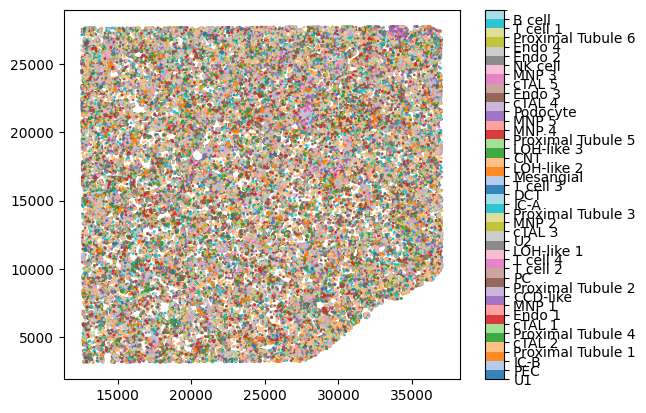

In [17]:
%matplotlib inline
import seaborn as sns
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['predicted'].unique()
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['predicted'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()


In [18]:
adata_st.obs['predicted'].value_counts()

predicted
U2                   24954
Proximal Tubule 1    17594
Proximal Tubule 2    12842
MNP 1                10691
cTAL 1               10232
PC                    8105
cTAL 3                7507
CNT                   7497
Mesangial             7094
Proximal Tubule 3     6988
Podocyte              6261
Endo 1                6037
LOH-like 1            5686
cTAL 2                5547
DCT                   4727
IC-A                  4431
MNP 3                 4285
cTAL 4                4029
LOH-like 3            4029
IC-B                  3917
LOH-like 2            3793
NK cell               3632
Proximal Tubule 4     3403
Endo 2                3385
Proximal Tubule 5     3374
T cell 2              3253
T cell 1              3103
MNP 2                 3008
PEC                   2948
U1                    2308
MNP 4                 2005
T cell 3              1969
Endo 3                1724
Endo 4                1536
Proximal Tubule 6     1468
T cell 4              1446
MNP 5             

In [19]:
ad_ge = tg.project_genes(
                  ad_map, 
                  adata_sc,
                  cluster_label='Cell_Types_Subclusters')

ad_ge.layers['raw_count'] = adata_st.to_df().reindex(ad_ge.var_names, axis=1).fillna(0)

In [20]:
celltypes = adata_sc.obs['Cell_Types_Subclusters'].unique()

mapping = {}
for ct3 in celltypes:
    value = adata_sc[adata_sc.obs['Cell_Types_Subclusters'] == ct3].obs['Cell_Types_Broad'].drop_duplicates().iloc[0]
    mapping[ct3] = value

adata_sc.obs['Cell_Types_Broad'].value_counts()

Cell_Types_Broad
Proximal Tubule    20771
cTAL                1156
LOH-like            1011
MNP                  999
T cell               938
Endothelial          572
NK cell              466
PC                   455
IC-A                 304
U1                   214
Mesangial            130
IC-B                 130
CNT                  122
DCT                  109
U2                   107
B cell                68
PEC                   64
CCD-like              45
Podocyte              16
Name: count, dtype: int64

In [21]:
ad_ge.layers['imputed_count'] = ad_ge.X.copy()

# Put X back as raw count 
ad_ge.X = ad_ge.layers['raw_count']

In [22]:
ad_ge.obs['predicted'] = adata_st.obs['predicted']

# relabel so I don't have to rename all the variables in the future cells
import gc
adata_st = ad_ge
gc.collect()

1805

In [23]:
del adata_sc
del markers
del ad_map
del exp
gc.collect()

145

In [24]:
sc.pp.log1p(adata_st)
adata_st.layers['normalized_count'] = adata_st.X.copy()

In [25]:
adata_st.var_names = adata_st.var_names.str.upper()
adata_st

AnnData object with n_obs × n_vars = 208144 × 22473
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'uniform_density', 'rna_count_based_density', 'predicted'
    var: 'n_cells', 'is_training'
    uns: 'training_genes', 'overlap_genes', 'log1p'
    layers: 'raw_count', 'imputed_count', 'normalized_count'

In [26]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.utils import clean_up_adata
from spaceoracle.tools.network import encode_labels


In [27]:
adata_st.obsm['spatial'] = spatial[['pxl_row_in_fullres', 'pxl_col_in_fullres']].loc[adata_st.obs_names].values

In [28]:
from spaceoracle.tools.utils import scale_adata

adata_st = scale_adata(adata_st, cell_size=8)
adata_st

AnnData object with n_obs × n_vars = 208144 × 22473
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'uniform_density', 'rna_count_based_density', 'predicted'
    var: 'n_cells', 'is_training'
    uns: 'training_genes', 'overlap_genes', 'log1p'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'raw_count', 'imputed_count', 'normalized_count'

In [29]:
adata_st.obs['ct3'] = adata_st.obs['predicted']
adata_st.obs['cell_type'] = adata_st.obs['ct3'].map(mapping)
adata_st.obs['cell_type'].value_counts()

cell_type
Proximal Tubule    45669
cTAL               27998
U2                 24954
MNP                21010
LOH-like           13508
Endothelial        12682
T cell              9771
PC                  8105
CNT                 7497
Mesangial           7094
Podocyte            6261
DCT                 4727
IC-A                4431
IC-B                3917
NK cell             3632
PEC                 2948
U1                  2308
B cell               875
CCD-like             757
Name: count, dtype: int64

In [30]:
adata_st.obs['cell_type'] = adata_st.obs['cell_type'].astype('category')
adata_st.obs['cell_type_int'] = adata_st.obs['cell_type'].apply(
    lambda x: encode_labels(adata_st.obs['cell_type'], reverse_dict=True)[x])


In [31]:
clean_up_adata(adata_st, ['cell_type', 'cell_type_int', 'spatial', 'ct3'])
adata_st


AnnData object with n_obs × n_vars = 208144 × 22473
    obs: 'ct3', 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'raw_count', 'imputed_count', 'normalized_count'

In [32]:
adata_st.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/human_kidney_visium.h5ad')

In [ ]:
import scanpy as sc 
adata_st = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/human_kidney_visium.h5ad')
adata_st

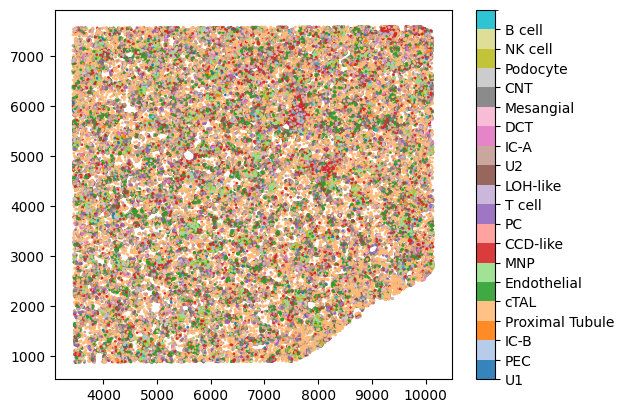

In [33]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['cell_type'].unique()

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['cell_type'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()
